### Data and dependencies

In [1]:
#importing libraries
import tensorflow as tf
import numpy as np
import keras 
import matplotlib.pyplot as plt
import seaborn as sns
import math
!pip install mido
import mido
from random import randint

     |████████████████████████████████| 51 kB 3.4 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model


> ## Defining the model

In [3]:
# custom layers for subclassed model
from keras import layers
class EncoderBlock(keras.layers.Layer):
    def __init__(self,units=200,name='encblock',**kwargs):
        super().__init__()
        self.conv1 = layers.Conv1D(filters=32,kernel_size=4,strides=4)
        self.conv2 = layers.Conv1D(filters=64,kernel_size=4,strides=2)
        self.blstm = layers.Bidirectional(layers.LSTM(units))
    def call(self,inputs):
        inputs=self.conv1(inputs)
        inputs=self.conv2(inputs)
        #n_steps = tf.shape(inputs)[1]
        hidden_state = self.blstm(inputs)
        return hidden_state
        #for i in range(n_steps): #backward pass
            #hidden_b,stateb = self.lstm_cell(inputs[n_steps-i-1,:],states=stateb) 
        #return tf.concat([hidden_f,hidden_b],axis=0)

class Sampling(keras.layers.Layer):
    def call(self,inputs):
        z_mean,z_log_var=inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5*z_log_var) * epsilon

class VIB_Block(keras.layers.Layer):
    def __init__(self,units2=500,latent_units=256,name='vib_block'):
        super().__init__()
        self.layer2=layers.Dense(units2)
        self.z_mean=layers.Dense(latent_units)
        self.z_log_var=layers.Dense(latent_units)
    def call(self,inputs):
        inputs=self.layer2(inputs)
        z_mean = self.z_mean(inputs)
        z_log_var = self.z_log_var(inputs)
        z = Sampling()([z_mean,z_log_var])
        return z


class ConductorRNN(keras.layers.Layer):
    def __init__(self,units=256,name='conductorRNN',**kwargs):
        super(ConductorRNN,self).__init__(name=name,**kwargs)
        self.lstm_cell = layers.LSTMCell(units)
    def call(self,x,num_splits):
        predictions=[]
        state=self.lstm_cell.get_initial_state(x)
        for i in range(num_splits):
            x,state = self.lstm_cell(x,states=state)
            predictions.append(x)
        return predictions
        
class InferenceDecoderLSTM(keras.layers.Layer):
    def __init__(self,units=256,name='inference_lstm',steps=32,**kwargs):
        super().__init__()
        self.lstm_cell1 = layers.LSTMCell(units)
        self.lstm_cell2 = layers.LSTMCell(units)
        self.dense1 = layers.Dense(9,activation='sigmoid',name='notes')
        self.dense2 = layers.Dense(9,activation='sigmoid',name='vel')
        self.dense3 = layers.Dense(9,activation='tanh',name='time')
    def call(self,c,initial_state,steps):
        predictions=[]
        state1=initial_state
        state2=self.lstm_cell2.get_initial_state(c)
        x=tf.zeros([c.shape[0],27]) # batch,27
        for i in range(steps):
            x,state1 = self.lstm_cell1(tf.concat([x,c],axis=1),states=state1) # (batch, 27+256) 
            x,state2 = self.lstm_cell2(x,states=state2)
            notes=self.dense1(x)
            vel=self.dense2(x)
            time=self.dense3(x)
            x=tf.concat([notes,vel,time],axis=1)
            predictions.append(x)
        return tf.stack(predictions,axis=1)

class State_Embedder(keras.layers.Layer):
    def __init__(self,units=256,name='state_Embedder',**kwargs):
        super().__init__()
        self.dense=layers.Dense(units*2,activation='tanh')
    def call(self,c):
        c=self.dense(c)
        return tf.split(c,2,axis=1)


In [4]:
class InferenceModel(keras.Model):
    def __init__(self,units_list,name='my_model',**kwargs):
        super(InferenceModel,self).__init__(name=name,**kwargs)
        units_enc,units2,latent_units,units_dec = units_list
        self.encblock1 = EncoderBlock(units_enc)
        self.encblock2 = EncoderBlock(units_enc)
        self.encblock3 = EncoderBlock(units_enc)
        self.vibblock = VIB_Block(units2=units2,latent_units=latent_units)
        self.conductor = ConductorRNN(latent_units)
        self.embedder = State_Embedder(units_dec)
        self.dec = InferenceDecoderLSTM(units=units_dec)
    def call(self,inputs,steps=32):
        #inputs
        X1,X2,X3 = inputs
        n_steps = X1.shape[1]
        #encoder
        x1 = self.encblock1(X1)
        x2 = self.encblock2(X2)
        x3 = self.encblock3(X3)
        z = self.vibblock(tf.concat([x1,x2,x3],axis=1))
        #decoder
        n_splits = math.ceil(n_steps/steps)
        remainder_steps = n_steps%steps
        c_embeddings = self.conductor(z,n_splits)
        dec_outputs = [] 
        for i,c in enumerate(c_embeddings):
            if i == n_splits-1 and remainder_steps>0: #last split and some steps left
                steps=remainder_steps
            subseq_output=self.dec(c=c,initial_state=self.embedder(c),steps=steps)
            dec_outputs.append(subseq_output)
        model_outputs=tf.concat(dec_outputs,axis=1) # (batch,n_steps,27)
        return model_outputs

In [5]:
units_enc,units2,latent_units,units_dec = 200,500,256,256 
model = InferenceModel(
    units_list=[units_enc,units2,latent_units,units_dec],
    name='Inference Model'
)
model.build([(1,128,128),(1,128,128),(1,128,128)])
model.summary()

Model: "Inference Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  448672    
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  448672    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  448672    
_________________________________________________________________
vib__block (VIB_Block)       multiple                  857012    
_________________________________________________________________
conductorRNN (ConductorRNN)  multiple                  525312    
_________________________________________________________________
state__embedder (State_Embed multiple                  131584    
_________________________________________________________________
inference_decoder_lstm (Infe multiple              

> ## loading weights to the model



In [6]:
"""#code used to create the list manually
for layer in model.layers:
    print(layer.name)
    print('\t', [w.shape for w in layer.get_weights()])
"""
manual_keys =[
    ['0/kernel','0/bias','3/kernel','3/bias',
    '6/forward_layer/cell/kernel','6/forward_layer/cell/recurrent_kernel','6/forward_layer/cell/bias',
    '6/backward_layer/cell/kernel','6/backward_layer/cell/recurrent_kernel','6/backward_layer/cell/bias',
    ],
    ['1/kernel','1/bias','4/kernel','4/bias',
    '7/forward_layer/cell/kernel','7/forward_layer/cell/recurrent_kernel','7/forward_layer/cell/bias',
    '7/backward_layer/cell/kernel','7/backward_layer/cell/recurrent_kernel','7/backward_layer/cell/bias',
    ],
    ['2/kernel','2/bias','5/kernel','5/bias',
    '8/forward_layer/cell/kernel','8/forward_layer/cell/recurrent_kernel','8/forward_layer/cell/bias',
    '8/backward_layer/cell/kernel','8/backward_layer/cell/recurrent_kernel','8/backward_layer/cell/bias',
    ],
    ['9/kernel','9/bias','10/kernel','10/bias','11/kernel','11/bias'],
    ['12/lstm_cell/kernel','12/lstm_cell/recurrent_kernel','12/lstm_cell/bias'],
    ['13/dense/kernel','13/dense/bias'],
    ['14/cell/kernel','14/cell/recurrent_kernel','14/cell/bias',
     '15/cell/kernel','15/cell/recurrent_kernel','15/cell/bias',
     '16/layer/kernel','16/layer/bias','17/layer/kernel','17/layer/bias','18/layer/kernel','18/layer/bias'
    ]]
for i,keylist in enumerate(manual_keys):
    for j,key in enumerate(keylist):
        manual_keys[i][j]= 'layer_with_weights-'+key+'/.ATTRIBUTES/VARIABLE_VALUE'

In [7]:
filepath='/content/drive/MyDrive/TM-backup/checkpoints_v8/tm-model-v8'
reader = tf.train.load_checkpoint(filepath)
shape_from_key = reader.get_variable_to_shape_map()
useful_keys=[]
for key in sorted(shape_from_key.keys()):
    if key[len(key)-28] == 's' or key[len(key)-28]=='l': # eliminates unnecessary keys (the ones used in the optimizer, etc.) 
            useful_keys.append(key)
for i,layer in enumerate(model.layers):
    layer.set_weights([reader.get_tensor(key) for key in manual_keys[i]])

## Plotting results (Histograms)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/TM/jupyter/TensorBoard/logs_model_v8

In [ ]:
def plot_instruments():
    print('\tgetting predictions and labels ...')
    predictions = model.predict(X_test)
    notes = predictions[:,:,:9]
    labels = array1_1

    instruments=['kick','snare','hi-hat closed','hi-hat open','tom3','tom2','tom1','ride','crash']
    for instr,name in enumerate(instruments):
        print(name)
        array_pred = notes[:,:,instr].flatten() # shape: 128*128*9
        array_true = labels[:,:,instr].flatten()

        positives=[]
        negatives=[]
        print('\tcomparing values...')
        for i,val in enumerate(array_pred):
            if array_true[i]==1:
                positives.append(val)
            else:
                negatives.append(val)
        #fig,ax = plt.subplots()
        print('\tcreating plots...')
        sns.histplot(positives,kde=True,color='blue',fill=False,)
        sns.histplot(negatives,kde=True,color='red',fill=False)
        plt.legend(('positives','negatives'))
        plt.plot()
        plt.show()

In [ ]:
def plot_values(hist=False):
    print('getting predictions and labels ...')
    predictions = model.predict(X_test)
    notes = predictions[:,:,:9].flatten()
    labels = array1_1.flatten()

    positives=[]
    negatives=[]
    for i,val in enumerate(notes):
        if labels[i]==1:
            positives.append(val)
        else:
            negatives.append(val)
    sns.kdeplot(positives,shade=True,legend=True)
    sns.kdeplot(negatives,shade=True,legend=True)
    plt.legend(('positives','negatives'))
    plt.plot()
    plt.show()
    #--------------------
    if hist:
        h_name=[]
        h_val=[]
        for var in history.history:
            h_name.append(var)
            h_val.append(history.history[var])


        l = int(len(h_name)/2)

        for i in range(l):
            plt.plot(h_val[i],label=h_name[i])
            plt.plot(h_val[i+l],label=h_name[i+l])
            plt.legend()
            plt.show()

	getting predictions and labels ...
kick
	comparing values...
	creating plots...


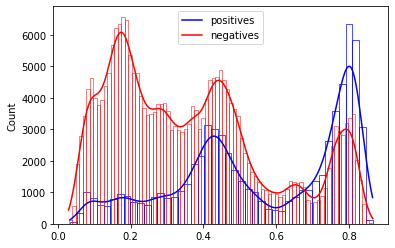

snare
	comparing values...
	creating plots...


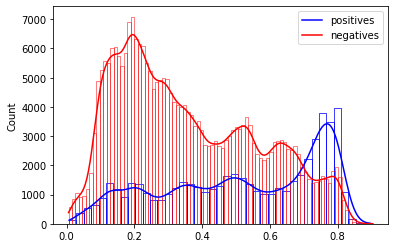

hi-hat closed
	comparing values...
	creating plots...


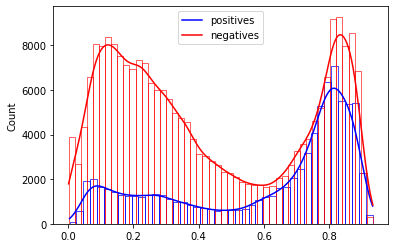

hi-hat open
	comparing values...
	creating plots...


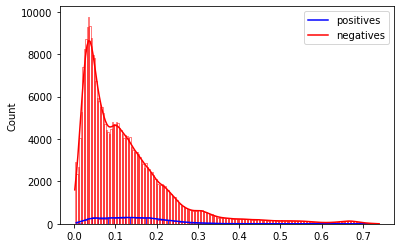

tom3
	comparing values...
	creating plots...


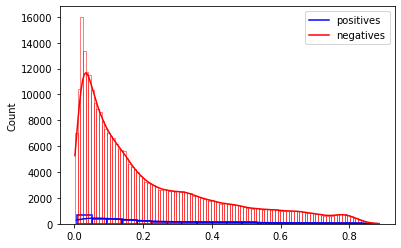

tom2
	comparing values...
	creating plots...


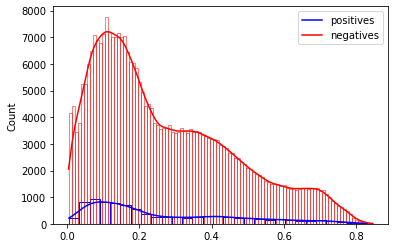

tom1
	comparing values...
	creating plots...


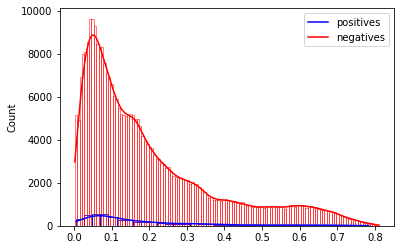

ride
	comparing values...
	creating plots...


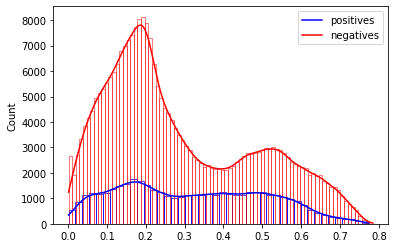

crash
	comparing values...
	creating plots...


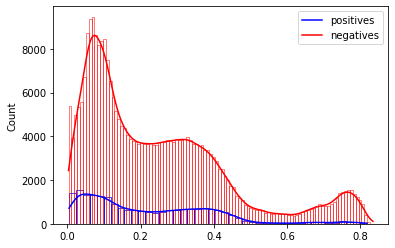

In [ ]:
plot_instruments()

	getting predictions and labels ...


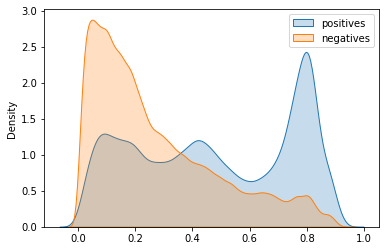

In [ ]:
plot_values()

### Inference

In [ ]:
!pip install mido
import mido
from random import randint

In [ ]:
"""def sample(notes,temp):
    notes=notes.reshape((128,9))
    for timestep in range(128):
        for i,note in enumerate(notes[timestep]):
            if note>temp:
                notes[timestep,i]=1
            else:
                notes[timestep,i]=0
    return notes

def array_to_midi(array,enctype=9):
    # array is of shape (128,9) with ones and zeros
    file=mido.MidiFile()
    file.ticks_per_beat=4
    track=mido.MidiTrack()
    file.tracks.append(track)
    track2=mido.MidiTrack()
    file.tracks.append(track2)
    
    
    bpm=100
    tempo=mido.bpm2tempo(bpm)
    ticks=4 # which gives 16 ticks per bar, so its quantized to 1/16th
    
    track.append(mido.MetaMessage('time_signature', numerator=4, denominator=4,time=0))
    track.append(mido.MetaMessage('set_tempo',tempo=tempo,time=0))
    track.append(mido.MetaMessage('key_signature',key='C',time=0))
    
    #---
    canonical_list=[36,38,42,43,46,47,49,50,51]
    ix_to_canonical={i:val for i,val in enumerate(canonical_list)}
    msgs=[]

    for timestep in range(array.shape[0]):  # 0-128
        for i,note in enumerate(array[timestep]):
            if note==1:
                msgs.append([
                             ix_to_canonical[i],
                             array[timestep,9+i]*127,
                             #timestep+array[timestep,18+i]
                             timestep #lets remove offset for now
                             ])

    
    #---
    # transforming from absolute time in ticks to delta time in ticks
    d=0
    for msg in msgs:
        d,msg[2]=msg[2],msg[2]-d   
    #----
    # adding note off msgs to other track (track2) to later merge both
    delta=1

    for i,msg in enumerate(msgs):
        track.append(mido.Message('note_on',channel=9,note=msg[0],velocity=int(msg[1]),time=int(msg[2])))
        if i==0:
            track2.append(mido.Message('note_off',channel=9,note=msg[0],velocity=int(msg[1]),time=int(msg[2])+delta))
        else:
            track2.append(mido.Message('note_off',channel=9,note=msg[0],velocity=int(msg[1]),time=int(msg[2])))
    new_track=mido.merge_tracks([track,track2])
    new_track.append(mido.MetaMessage('end_of_track',time=0))
    file.tracks.append(new_track)
    file.tracks.remove(track)
    file.tracks.remove(track2)
    
    return file


def inference(n=None,temp=0.8):
    global model
    if n is None:
        n=randint(0,m-1)
    print(n)

    predictions = model.predict_on_batch([arr[n,:,:].reshape((1,128,128)) for arr in X_test])
    predictions_ones = sample(predictions[:,:,:9],temp)
    print(predictions_ones)

    midifile = array_to_midi(np.concatenate([predictions_ones,predictions[:,:,9:].reshape((128,18))],axis=1),enctype=9)
    midifile.save(f'8bar_generated-tm-v8-{n}.mid')
    midifile.print_tracks()"""

In [ ]:
inference(temp=0.5)

2378
[[1. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
=== Track 0
MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('set_tempo', tempo=600000, time=0)
MetaMessage('key_signature', key='C', time=0)
Message('note_on', channel=9, note=36, velocity=77, time=0)
Message('note_on', channel=9, note=42, velocity=55, time=0)
Message('note_on', channel=9, note=50, velocity=16, time=0)
Message('note_off', channel=9, note=36, velocity=77, time=1)
Message('note_off', channel=9, note=42, velocity=55, time=0)
Message('note_off', channel=9, note=50, velocity=16, time=0)
Message('note_on', channel=9, note=42, velocity=32, time=1)
Message('note_on', channel=9, note=42, velocity=15, time=1)
Message('note_off', channel=9, note=42, velocity=32, time=0)
Message('note_on', channel=9, note=38, velocity=56, time=1)
Message('not

In [ ]:
#archive of good ones:
    #2378

## Variable-sized inputs (inference test on real music)

In [8]:
def array_on_track(track,ticks):
    first_array = np.zeros(shape=(len(track),3))
    time = 0 #ticks
    for i,msg in enumerate(track):
        time+=msg.time
        if msg.type=='control_change' or msg.type=='program_change' or msg.type=='note_off':
            continue
        elif not msg.is_meta: # we only want note_on messages
            first_array[i,0]=1
            first_array[i,1]=msg.bytes()[1] #note_value 0..127
            first_array[i,2]=round(time*4/ticks) #quantized time in ticks
    # we have now an event-based list of notes
    # let's transform it into a time series with note value on the second dimension
    
    second_array = np.zeros(shape=(round(time*4/ticks),128))
    for note in first_array:
        if note[0]==1:
            second_array[int(note[2]),int(note[1])]=1
    # in doing so, we skipped the data regarding velocity and note_off events
    # but, as this is just the input for the model and won't be used to create midifiles,
    # we can allow ourselves to simplify the data 
    return second_array

In [9]:
def drum_array_on_track(track,ticks):
    first_array = np.zeros(shape=(len(track),5))
    time = 0 #ticks
    
    #converting standard drum notation to indexes 0-8
    gm_to_ix ={
        35:0,36:0,
        37:1,38:1,39:1,40:1,
        42:2,44:2,
        46:3,
        41:4,43:4,
        45:5,47:5,
        48:6,50:6,
        51:7,53:7,59:7,
        49:8,52:8,55:8,57:8
    }
    #kick,snare,HHc,HHo,tom3,tom2,tom1,ride,crash
    #0   ,1    ,2  ,3  ,4   ,5   ,6   ,7   ,8
    
    for i,msg in enumerate(track):
        time+=msg.time
        if msg.type=='control_change' or msg.type=='program_change' or msg.type=='note_off':
            continue
        elif not msg.is_meta:
            if msg.bytes()[1] in gm_to_ix.keys(): # to prevent key errors
                first_array[i,0]=1 #note or no note 
                first_array[i,1]=gm_to_ix[msg.bytes()[1]] #note_value 0-8
                first_array[i,2]=msg.bytes()[2]/127 #velocity : float 0..1
                first_array[i,3]=round(time*4/ticks) #quantized time in ticks
                first_array[i,4]=(time*4/ticks)-round(time*4/ticks) #offset in ticks
    #####
    #let's create the time series array:
    second_array=np.zeros((round(time*4/ticks),27))
    
    for note in first_array:
        if note[0]==1:
            second_array[int(note[3]),int(note[1])]=1 # note
            second_array[int(note[3]),9+int(note[1])]=note[2] # vel
            second_array[int(note[3]),18+int(note[1])]=note[4] # time offset
    return second_array 

In [10]:
def create_arrays(filename):
    file = mido.MidiFile(filename)

    ticks = file.ticks_per_beat
    
    piano_ix=[]
    guitar_ix=[]
    bass_ix=[]
    #i_drums=-1
    piano_range = range(0,8)
    guitar_range = range(24,32)
    bass_range = range(32,40)
    
    ##### filtering tracks:
    for i,track in enumerate(file.tracks):
        for msg in track[0:20]:
            if msg.is_meta == False:
                if msg.type=='program_change':
                    #if msg.dict()['channel'] ==9:
                    #    i_drums=i
                    if msg.dict()['program'] in piano_range:
                        piano_ix.append(i)
                    elif msg.dict()['program'] in guitar_range:
                        guitar_ix.append(i)
                    elif msg.dict()['program'] in bass_range:
                        bass_ix.append(i)
    #####
    created=False
    #drum_array1 = drum_array_on_track(file.tracks[i_drums],ticks)
    #max_length = drum_array1.shape[0]
    max_length=None
    combinations = []
    for i_piano in piano_ix:
        for i_guitar in guitar_ix:
            for i_bass in bass_ix:
                #this loops over all possibilities for these instruments 
                piano_array1 = array_on_track(file.tracks[i_piano],ticks)
                guitar_array1 = array_on_track(file.tracks[i_guitar],ticks)
                bass_array1 = array_on_track(file.tracks[i_bass],ticks)

                max_length = bass_array1.shape[0] if max_length is None else max_length
                
                piano_final=piano_array1[:max_length,:].copy().reshape(1,max_length,128)
                guitar_final=guitar_array1[:max_length,:].copy().reshape(1,max_length,128)
                bass_final=bass_array1[:max_length,:].copy().reshape(1,max_length,128)
                combinations.append([piano_final,guitar_final,bass_final])
    return combinations #,drum_array1

In [11]:
def sample(notes,temp):
    length=notes.shape[len(notes.shape)-2]
    notes=notes.numpy().reshape((length,9))
    for timestep in range(length):
        for i,note in enumerate(notes[timestep]):
            if note>temp:
                notes[timestep,i]=1
            else:
                notes[timestep,i]=0
    return notes

In [16]:
def array_to_midi(array,filename,remove_real_drums=False):
    """ "array" is of shape (length,27) with ones and zeros at first, then float predictions.
        "filename" is the file name of the original midi song (without drums preferably)
    """

    file=mido.MidiFile(filename)
    upscale_factor = file.ticks_per_beat/4 
    
    if remove_real_drums:
        percussions=[]
        for i,track in enumerate(file.tracks):
            for msg in track[0:20]:
                if msg.is_meta == False:
                    if msg.type=='program_change':
                        if msg.dict()['channel'] ==9:
                            percussions.append(track)
        for track in percussions:
            file.tracks.remove(track)
    
    track=mido.MidiTrack()
    file.tracks.append(track)
    track2=mido.MidiTrack()
    file.tracks.append(track2)
    track_quantized=mido.MidiTrack()
    file.tracks.append(track_quantized)
    track_quantized2=mido.MidiTrack()
    file.tracks.append(track_quantized2)
    
    #---
    canonical_list=[36,38,42,43,46,47,49,50,51]
    ix_to_canonical={i:val for i,val in enumerate(canonical_list)}
    msgs=[]

    for timestep in range(array.shape[0]):
        for i,note in enumerate(array[timestep,:9]):
            if note==1:
                if timestep!=0:
                    msgs.append([
                                ix_to_canonical[i],
                                round(array[timestep,9+i]*127),
                                round((timestep+array[timestep,18+i])*upscale_factor)
                                ])
                else:
                    msgs.append([
                                ix_to_canonical[i],
                                round(array[timestep,9+i]*127),
                                round(timestep*upscale_factor) # to prevent a negative time for the first message
                                ])
    for msg in msgs: # after some tests i realized that the drums volume was too low 
        new_vel = int(msg[1]*1.8) if msg[0]!=38 else int(msg[1]*2.5)
        msg[1]= new_vel if new_vel<=127 else 127

    #---
    # transforming from absolute time in ticks to delta time in ticks
    d=0
    for msg in msgs:
        d,msg[2]=msg[2],msg[2]-d  #python is beautiful 
        # d is absolute time of previous message,
        # msg[2] (=the msg's absolute time) now becomes the difference between the absolute times of itself and the previous msg
    #----
    # adding note off msgs to other track (track2) to later merge both
    delta=1*upscale_factor

    for i,msg in enumerate(msgs):
        track.append(mido.Message('note_on',channel=9,note=msg[0],velocity=int(msg[1]),time=int(msg[2])))
        track_quantized.append(mido.Message('note_on',channel=9,note=msg[0],velocity=90,time=int(upscale_factor*round(msg[2]/upscale_factor))))
        if i==0:
            track2.append(mido.Message('note_off',channel=9,note=msg[0],velocity=int(msg[1]),time=int(msg[2]+delta)))
            track_quantized2.append(mido.Message('note_off',channel=9,note=msg[0],velocity=90,time=int(upscale_factor*round(msg[2]/upscale_factor)+delta)))
        else:
            track2.append(mido.Message('note_off',channel=9,note=msg[0],velocity=int(msg[1]),time=int(msg[2])))
            track_quantized2.append(mido.Message('note_off',channel=9,note=msg[0],velocity=90,time=int(upscale_factor*round(msg[2]/upscale_factor))))
    new_track=mido.merge_tracks([track,track2])
    new_track.name='generated_drums'

    new_track_quantized=mido.merge_tracks([track_quantized,track_quantized2])
    new_track_quantized.name='quantized_drums'

    file.tracks.append(new_track)
    file.tracks.remove(track)
    file.tracks.remove(track2)
    file.tracks.append(new_track_quantized)
    file.tracks.remove(track_quantized)
    file.tracks.remove(track_quantized2)
    return file

In [17]:
def evaluate_rythms(rythms):
    """ Construisons une fonction pour choisir le meilleur rythme de batterie parmi tous ceux générés.
        J'ai 2 approches en tête: la première est de modéliser et d'entraîner un petit modèle "discriminant",
        potentiellement similaire à la deuxième partie d'un GAN;
        la deuxième – plus simple – serait de créer une fonction discriminante à la main,
        en évaluant par exemple la distance moyenne des rythmes générés à un "rythme type" arbitraire, judicieusement choisi. 
        (Ainsi on peut pénaliser les rythmes à la fois trop simples ou trop complexes)
        NB: l'input "rythms" est une liste de la forme [notes générées, prédictions , température].
    """
    #Ci-dessous se trouve un rythme (sous forme de matrice) assez basique, mais suffisant pour faire office d'exemple et classer les rythmes générés.
    baseline_rythm = np.array( 
        [[1,0,1,0,0,0,0,0,1],[0,0,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],
        [0,1,1,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],
        [1,0,1,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[1,0,1,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],
        [0,1,1,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,1,1,0,0,0,0,0],[0,0,0,0,0,0,0,0,0]])
    discriminating_fx = keras.metrics.Accuracy()
    metrics=[]
    length=rythms[0][0].shape[0]
    labels= np.tile(baseline_rythm, [math.ceil(length/baseline_rythm.shape[0]),1])[:length,:]
    for r in rythms:
        metrics.append(discriminating_fx(labels,r[0]))
    return rythms[metrics.index(max(metrics))]

In [18]:
def real_inference(file,model,temp=None,dec_steps=32):
    n= input('test number? (for filename) : ')
    if temp is None:
        temp_range=[0.6,0.62,0.64]
    elif type(temp) is float:
        temp_range=[temp]

    combinations = create_arrays(file) 
    rythms = []
    for i,combination in enumerate(combinations):
        predictions = model(inputs=combination,steps=dec_steps)
        for temp in temp_range:
            predictions_ones = sample(predictions[:,:,:9],temp)
            rythms.append([predictions_ones,predictions,temp])

    predictions_ones,chosen_predictions,final_temp = evaluate_rythms(rythms)
    chosen_predictions= chosen_predictions[:,:,9:].numpy().reshape((predictions_ones.shape[0],18))
    final_predictions = np.concatenate([predictions_ones,chosen_predictions],axis=1)

    midifile = array_to_midi(final_predictions,file)
    midifile.save(f'inference-test-v8-file-{n}.mid')
    print('temp :',final_temp)
    print('decoder steps :',dec_steps)

In [19]:
real_inference('/content/drive/MyDrive/TM-backup/Sofarawayfromme.mid',model,temp=0.62,dec_steps=16)

test number? (for filename) : 11
temp : 0.62
decoder steps : 16
